In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [89]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [90]:
# set important parameters
l_rate = 0.001
batch_size = 4
n_epochs = 4

In [91]:
# PIL image range of [0, 1] dataset is transformed into tensor and normalized in range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 data & transformation of data into tensor
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())
print(train_data, test_data)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [92]:
# load batchsize of 100
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(train_loader)

In [93]:
# label classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [94]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

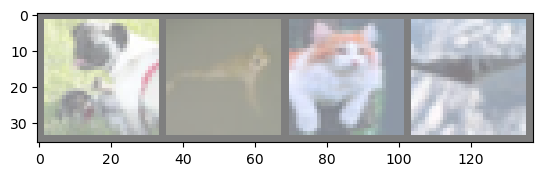

In [95]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [96]:
# CNN implementation
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 2 covolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 3 flattern layers
        self.fc1 = nn.Linear(16*5*5, 120) # after 2 covolutions, the correct image size = [4, 16, 5, 5]
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, inputs):
        # -> n, 3, 32, 32
        inputs = self.pool(F.relu(self.conv1(inputs)))  # -> n, 6, 14, 14
        inputs = self.pool(F.relu(self.conv2(inputs)))  # -> n, 16, 5, 5
        inputs = inputs.view(-1, 16*5*5)            # -> n, 400
        inputs = F.relu(self.fc1(inputs))               # -> n, 120
        inputs = F.relu(self.fc2(inputs))               # -> n, 84
        inputs = self.fc3(inputs)                       # -> n, 10
        return inputs

In [97]:
model = CNN().to(device)

In [98]:
# loss and optimizer
criterion =  nn.CrossEntropyLoss() # nn.CrossEntropyLoss() automaticsally applies Softmax
optimizer = torch.optim.SGD(model.parameters(), lr=l_rate)

In [99]:
# training loop
n_steps = len(train_loader)
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # shape: 4, 3, 32, 32 = 4, 3, 1024
        # input layer: 3 input channels, 6 input channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        out = model(images)
        loss = criterion(out, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print(f'epoch {epoch+1} / {n_epochs}, step {i+1} / {n_steps}, loss = {loss.item():.4f}')

epoch 1 / 4, step 2000 / 12500, loss = 2.3295
epoch 1 / 4, step 4000 / 12500, loss = 2.3101
epoch 1 / 4, step 6000 / 12500, loss = 2.2886
epoch 1 / 4, step 8000 / 12500, loss = 2.2856
epoch 1 / 4, step 10000 / 12500, loss = 2.2928
epoch 1 / 4, step 12000 / 12500, loss = 2.2461
epoch 2 / 4, step 2000 / 12500, loss = 2.2908
epoch 2 / 4, step 4000 / 12500, loss = 1.6579
epoch 2 / 4, step 6000 / 12500, loss = 2.1317
epoch 2 / 4, step 8000 / 12500, loss = 2.1851
epoch 2 / 4, step 10000 / 12500, loss = 2.1735
epoch 2 / 4, step 12000 / 12500, loss = 2.2281
epoch 3 / 4, step 2000 / 12500, loss = 1.8577
epoch 3 / 4, step 4000 / 12500, loss = 1.3832
epoch 3 / 4, step 6000 / 12500, loss = 1.3559
epoch 3 / 4, step 8000 / 12500, loss = 1.6669
epoch 3 / 4, step 10000 / 12500, loss = 1.0200
epoch 3 / 4, step 12000 / 12500, loss = 2.4279
epoch 4 / 4, step 2000 / 12500, loss = 1.5443
epoch 4 / 4, step 4000 / 12500, loss = 1.6111
epoch 4 / 4, step 6000 / 12500, loss = 2.1399
epoch 4 / 4, step 8000 / 125

In [100]:
# testing model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        out = model(images)
        
        # value, index
        _, predictions = torch.max(out, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predictions[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
    accuracy = 100.0 * n_correct / n_samples
    print(f'CNN network accuracy = {accuracy}')
    
    for i in range(10):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'accuracy of class {classes[i]}: {accuracy} %')

CNN network accuracy = 39.93
accuracy of class truck: 47.5 %
